In [1]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = "retina"

# Far-field plotting functions

In [2]:
def plot_fields(elements, x, y, displacement, stress, sup_title):
    """Contour 2 displacement fields, 3 stress fields, and quiver displacements"""
    x_lim = np.array([x.min(), x.max()])
    y_lim = np.array([y.min(), y.max()])

    def style_plots():
        """Common plot elements"""
        plt.gca().set_aspect("equal")
        plt.xticks([x_lim[0], x_lim[1]])
        plt.yticks([y_lim[0], y_lim[1]])

    def plot_subplot(elements, x, y, idx, field, title):
        """Common elements for each subplot - other than quiver"""
        plt.subplot(2, 3, idx)
        field_max = np.max(np.abs(field))
        scale = 5e-1
        plt.contourf(
            x,
            y,
            field.reshape(x.shape),
            n_contours,
            vmin=-scale * field_max,
            vmax=scale * field_max,
            cmap=plt.get_cmap("RdYlBu"),
        )
        plt.clim(-scale * field_max, scale * field_max)
        plt.colorbar(fraction=0.046, pad=0.04, extend="both")

        plt.contour(
            x,
            y,
            field.reshape(x.shape),
            n_contours,
            vmin=-scale * field_max,
            vmax=scale * field_max,
            linewidths=0.25,
            colors="k",
        )

        for element in elements:
            plt.plot(
                [element["x1"], element["x2"]],
                [element["y1"], element["y2"]],
                "-k",
                linewidth=1.0,
            )
        plt.title(title)
        style_plots()

    plt.figure(figsize=(12, 8))
    n_contours = 10
    plot_subplot(elements, x, y, 2, displacement[0, :], "x displacement")
    plot_subplot(elements, x, y, 3, displacement[1, :], "y displacement")
    plot_subplot(elements, x, y, 4, stress[0, :], "xx stress")
    plot_subplot(elements, x, y, 5, stress[1, :], "yy stress")
    plot_subplot(elements, x, y, 6, stress[2, :], "xy stress")

    plt.subplot(2, 3, 1)
    for element in elements:
        plt.plot(
            [element["x1"], element["x2"]],
            [element["y1"], element["y2"]],
            "-k",
            linewidth=1.0,
        )

    plt.quiver(x, y, displacement[0], displacement[1], units="width", color="b")

    plt.title("vector displacement")
    plt.gca().set_aspect("equal")
    plt.xticks([x_lim[0], x_lim[1]])
    plt.yticks([y_lim[0], y_lim[1]])
    plt.suptitle(sup_title)
    plt.tight_layout()
    plt.show(block=False)


def plot_element_geometry(elements):
    """Plot element geometry"""
    for element in elements:
        plt.plot(
            [element["x1"], element["x2"]],
            [element["y1"], element["y2"]],
            "-k",
            color="r",
            linewidth=0.5,
        )
        plt.plot(
            [element["x1"], element["x2"]],
            [element["y1"], element["y2"]],
            "r.",
            markersize=1,
            linewidth=0.5,
        )

    # Extract and plot unit normal vectors
    x_center = np.array([_["x_center"] for _ in elements])
    y_center = np.array([_["y_center"] for _ in elements])
    x_normal = np.array([_["x_normal"] for _ in elements])
    y_normal = np.array([_["y_normal"] for _ in elements])
    plt.quiver(
        x_center, y_center, x_normal, y_normal, units="width", color="gray", width=0.002
    )

    for i, element in enumerate(elements):
        plt.text(
            element["x_center"],
            element["y_center"],
            str(i),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("element geometry and normals")
    plt.gca().set_aspect("equal")
    plt.show(block=False)


# Element management utility functions

In [3]:
def standardize_elements(elements):
    for element in elements:
        element["angle"] = np.arctan2(
            element["y2"] - element["y1"], element["x2"] - element["x1"]
        )
        element["length"] = np.sqrt(
            (element["x2"] - element["x1"]) ** 2 + (element["y2"] - element["y1"]) ** 2
        )
        element["half_length"] = 0.5 * element["length"]
        element["x_center"] = 0.5 * (element["x2"] + element["x1"])
        element["y_center"] = 0.5 * (element["y2"] + element["y1"])
        element["rotation_matrix"] = np.array(
            [
                [np.cos(element["angle"]), -np.sin(element["angle"])],
                [np.sin(element["angle"]), np.cos(element["angle"])],
            ]
        )
        element["inverse_rotation_matrix"] = np.array(
            [
                [np.cos(-element["angle"]), -np.sin(-element["angle"])],
                [np.sin(-element["angle"]), np.cos(-element["angle"])],
            ]
        )
        dx = element["x2"] - element["x1"]
        dy = element["y2"] - element["y1"]
        mag = np.sqrt(dx**2 + dy**2)
        element["x_normal"] = dy / mag
        element["y_normal"] = -dx / mag

        # Evaluations points for quadratic kernels
        element["x_integration_points"] = np.array(
            [
                element["x_center"] - (2 / 3 * dx / 2),
                element["x_center"],
                element["x_center"] + (2 / 3 * dx / 2),
            ]
        )
        element["y_integration_points"] = np.array(
            [
                element["y_center"] - (2 / 3 * dy / 2),
                element["y_center"],
                element["y_center"] + (2 / 3 * dy / 2),
            ]
        )

        # If a local boundary condition is giving convert to global
        # TODO: This is just for convenience there should be flags for real BCs
        if "ux_local" in element:
            u_local = np.array([element["ux_local"], element["uy_local"]])
            u_global = element["rotation_matrix"] @ u_local
            element["ux_global_constant"] = u_global[0]
            element["uy_global_constant"] = u_global[1]
            element["ux_global_quadratic"] = np.repeat(u_global[0], 3)
            element["uy_global_quadratic"] = np.repeat(u_global[1], 3)

    return elements


def discretized_line(x_start, y_start, x_end, y_end, n_elements):
    """Create geometry of discretized line"""
    n_pts = n_elements + 1
    x = np.linspace(x_start, x_end, n_pts)
    y = np.linspace(y_start, y_end, n_pts)
    x1 = x[:-1]
    y1 = y[:-1]
    x2 = x[1:]
    y2 = y[1:]
    return x1, y1, x2, y2


# Constant and quadratic slip kernels

In [4]:
def constant_kernel(x, y, a, nu):
    """From Starfield and Crouch, pages 49 and 82"""
    f = np.zeros((7, x.size))

    f[0, :] = (
        -1
        / (4 * np.pi * (1 - nu))
        * (
            y * (np.arctan2(y, (x - a)) - np.arctan2(y, (x + a)))
            - (x - a) * np.log(np.sqrt((x - a) ** 2 + y**2))
            + (x + a) * np.log(np.sqrt((x + a) ** 2 + y**2))
        )
    )

    f[1, :] = (
        -1
        / (4 * np.pi * (1 - nu))
        * ((np.arctan2(y, (x - a)) - np.arctan2(y, (x + a))))
    )

    f[2, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (
            np.log(np.sqrt((x - a) ** 2 + y**2))
            - np.log(np.sqrt((x + a) ** 2 + y**2))
        )
    )

    f[3, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (y / ((x - a) ** 2 + y**2) - y / ((x + a) ** 2 + y**2))
    )

    f[4, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * ((x - a) / ((x - a) ** 2 + y**2) - (x + a) / ((x + a) ** 2 + y**2))
    )

    f[5, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (
            ((x - a) ** 2 - y**2) / ((x - a) ** 2 + y**2) ** 2
            - ((x + a) ** 2 - y**2) / ((x + a) ** 2 + y**2) ** 2
        )
    )

    f[6, :] = (
        2
        * y
        / (4 * np.pi * (1 - nu))
        * (
            (x - a) / ((x - a) ** 2 + y**2) ** 2
            - (x + a) / ((x + a) ** 2 + y**2) ** 2
        )
    )
    return f


def quadratic_kernel_farfield(x, y, a, nu):
    """Kernels with quadratic shape functions
    f has dimensions of (f=7, shapefunctions=3, n_obs)

    Classic form of:
    arctan_x_minus_a = np.arctan((a - x) / y)
    arctan_x_plus_a = np.arctan((a + x) / y)

    but we have replaced these with the equaivalaent terms below to
    avoid singularities at y = 0.  Singularities at x = +/- a still exist
    """

    arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
    arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))

    f = np.zeros((7, 3, x.size))

    # f0
    f[0, 0, :] = (
        -1
        / 64
        * (
            6 * y**3 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a**3 * np.log(a**2 + 2 * a * x + x**2 + y**2)
            - 8 * a**3
            - 12 * a**2 * x
            + 12 * a * x**2
            - 12 * a * y**2
            + 6
            * (
                (2 * a * x - 3 * x**2) * arctan_x_plus_a
                + (2 * a * x - 3 * x**2) * arctan_x_minus_a
            )
            * y
            + 3
            * (a * x**2 - x**3 - (a - 3 * x) * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 3
            * (a * x**2 - x**3 - (a - 3 * x) * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[0, 1, :] = (
        1
        / 32
        * (
            6 * y**3 * (arctan_x_plus_a + arctan_x_minus_a)
            + a**3 * np.log(a**2 + 2 * a * x + x**2 + y**2)
            + a**3 * np.log(a**2 - 2 * a * x + x**2 + y**2)
            - 8 * a**3
            + 12 * a * x**2
            - 12 * a * y**2
            + 2
            * (
                (4 * a**2 - 9 * x**2) * arctan_x_plus_a
                + (4 * a**2 - 9 * x**2) * arctan_x_minus_a
            )
            * y
            + (4 * a**2 * x - 3 * x**3 + 9 * x * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - (4 * a**2 * x - 3 * x**3 + 9 * x * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[0, 2, :] = (
        -1
        / 64
        * (
            6 * y**3 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a**3 * np.log(a**2 - 2 * a * x + x**2 + y**2)
            - 8 * a**3
            + 12 * a**2 * x
            + 12 * a * x**2
            - 12 * a * y**2
            - 6
            * (
                (2 * a * x + 3 * x**2) * arctan_x_plus_a
                + (2 * a * x + 3 * x**2) * arctan_x_minus_a
            )
            * y
            - 3
            * (a * x**2 + x**3 - (a + 3 * x) * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + 3
            * (a * x**2 + x**3 - (a + 3 * x) * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    # f1
    f[1, 0, :] = (
        -3
        / 32
        * (
            3 * y**2 * (arctan_x_plus_a + arctan_x_minus_a)
            - (a - 3 * x) * y * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + (a - 3 * x) * y * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
            - 6 * a * y
            + (2 * a * x - 3 * x**2) * arctan_x_plus_a
            + (2 * a * x - 3 * x**2) * arctan_x_minus_a
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[1, 1, :] = (
        1
        / 16
        * (
            9 * y**2 * (arctan_x_plus_a + arctan_x_minus_a)
            + 9 * x * y * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 9 * x * y * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
            - 18 * a * y
            + (4 * a**2 - 9 * x**2) * arctan_x_plus_a
            + (4 * a**2 - 9 * x**2) * arctan_x_minus_a
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[1, 2, :] = (
        -3
        / 32
        * (
            3 * y**2 * (arctan_x_plus_a + arctan_x_minus_a)
            + (a + 3 * x) * y * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - (a + 3 * x) * y * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
            - 6 * a * y
            - (2 * a * x + 3 * x**2) * arctan_x_plus_a
            - (2 * a * x + 3 * x**2) * arctan_x_minus_a
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    # f2
    f[2, 0, :] = (
        3
        / 64
        * (
            8 * a**2
            - 12 * a * x
            - 4 * ((a - 3 * x) * arctan_x_plus_a + (a - 3 * x) * arctan_x_minus_a) * y
            - (2 * a * x - 3 * x**2 + 3 * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + (2 * a * x - 3 * x**2 + 3 * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[2, 1, :] = (
        1
        / 32
        * (
            36 * a * x
            - 36 * (x * arctan_x_plus_a + x * arctan_x_minus_a) * y
            + (4 * a**2 - 9 * x**2 + 9 * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - (4 * a**2 - 9 * x**2 + 9 * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    f[2, 2, :] = (
        -3
        / 64
        * (
            8 * a**2
            + 12 * a * x
            - 4 * ((a + 3 * x) * arctan_x_plus_a + (a + 3 * x) * arctan_x_minus_a) * y
            - (2 * a * x + 3 * x**2 - 3 * y**2)
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + (2 * a * x + 3 * x**2 - 3 * y**2)
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (np.pi * a**2 * nu - np.pi * a**2)
    )

    # f3
    f[3, 0, :] = (
        3
        / 32
        * (
            4 * a**2 * y**3
            - 2
            * ((a - 3 * x) * arctan_x_plus_a + (a - 3 * x) * arctan_x_minus_a)
            * y**4
            - 4
            * (
                (a**3 - 3 * a**2 * x + a * x**2 - 3 * x**3) * arctan_x_plus_a
                + (a**3 - 3 * a**2 * x + a * x**2 - 3 * x**3) * arctan_x_minus_a
            )
            * y**2
            + 4 * (a**4 - 3 * a**3 * x + a**2 * x**2) * y
            - 2
            * (
                a**5
                - 3 * a**4 * x
                - 2 * a**3 * x**2
                + 6 * a**2 * x**3
                + a * x**4
                - 3 * x**5
            )
            * arctan_x_plus_a
            - 2
            * (
                a**5
                - 3 * a**4 * x
                - 2 * a**3 * x**2
                + 6 * a**2 * x**3
                + a * x**4
                - 3 * x**5
            )
            * arctan_x_minus_a
            - 3
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + 3
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    f[3, 1, :] = (
        1
        / 16
        * (
            20 * a**3 * x * y
            - 18 * (x * arctan_x_plus_a + x * arctan_x_minus_a) * y**4
            - 36
            * (
                (a**2 * x + x**3) * arctan_x_plus_a
                + (a**2 * x + x**3) * arctan_x_minus_a
            )
            * y**2
            - 18 * (a**4 * x - 2 * a**2 * x**3 + x**5) * arctan_x_plus_a
            - 18 * (a**4 * x - 2 * a**2 * x**3 + x**5) * arctan_x_minus_a
            + 9
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 9
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    f[3, 2, :] = (
        -3
        / 32
        * (
            4 * a**2 * y**3
            - 2
            * ((a + 3 * x) * arctan_x_plus_a + (a + 3 * x) * arctan_x_minus_a)
            * y**4
            - 4
            * (
                (a**3 + 3 * a**2 * x + a * x**2 + 3 * x**3) * arctan_x_plus_a
                + (a**3 + 3 * a**2 * x + a * x**2 + 3 * x**3) * arctan_x_minus_a
            )
            * y**2
            + 4 * (a**4 + 3 * a**3 * x + a**2 * x**2) * y
            - 2
            * (
                a**5
                + 3 * a**4 * x
                - 2 * a**3 * x**2
                - 6 * a**2 * x**3
                + a * x**4
                + 3 * x**5
            )
            * arctan_x_plus_a
            - 2
            * (
                a**5
                + 3 * a**4 * x
                - 2 * a**3 * x**2
                - 6 * a**2 * x**3
                + a * x**4
                + 3 * x**5
            )
            * arctan_x_minus_a
            + 3
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 3
            * (
                y**5
                + 2 * (a**2 + x**2) * y**3
                + (a**4 - 2 * a**2 * x**2 + x**4) * y
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    # f4
    f[4, 0, :] = (
        3
        / 32
        * (
            6 * y**5 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a**5
            - 4 * a**4 * x
            + 18 * a**3 * x**2
            + 4 * a**2 * x**3
            - 12 * a * x**4
            - 12 * a * y**4
            + 12
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**3
            - 2 * (9 * a**3 - 2 * a**2 * x + 12 * a * x**2) * y**2
            + 6
            * (
                (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_plus_a
                + (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_minus_a
            )
            * y
            - (
                a**5
                - 3 * a**4 * x
                - 2 * a**3 * x**2
                + 6 * a**2 * x**3
                + a * x**4
                - 3 * x**5
                + (a - 3 * x) * y**4
                + 2 * (a**3 - 3 * a**2 * x + a * x**2 - 3 * x**3) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + (
                a**5
                - 3 * a**4 * x
                - 2 * a**3 * x**2
                + 6 * a**2 * x**3
                + a * x**4
                - 3 * x**5
                + (a - 3 * x) * y**4
                + 2 * (a**3 - 3 * a**2 * x + a * x**2 - 3 * x**3) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    f[4, 1, :] = (
        -1
        / 16
        * (
            18 * y**5 * (arctan_x_plus_a + arctan_x_minus_a)
            - 26 * a**5
            + 62 * a**3 * x**2
            - 36 * a * x**4
            - 36 * a * y**4
            + 36
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**3
            - 2 * (31 * a**3 + 36 * a * x**2) * y**2
            + 18
            * (
                (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_plus_a
                + (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_minus_a
            )
            * y
            + 9
            * (
                a**4 * x
                - 2 * a**2 * x**3
                + x**5
                + x * y**4
                + 2 * (a**2 * x + x**3) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 9
            * (
                a**4 * x
                - 2 * a**2 * x**3
                + x**5
                + x * y**4
                + 2 * (a**2 * x + x**3) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    f[4, 2, :] = (
        3
        / 32
        * (
            6 * y**5 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a**5
            + 4 * a**4 * x
            + 18 * a**3 * x**2
            - 4 * a**2 * x**3
            - 12 * a * x**4
            - 12 * a * y**4
            + 12
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**3
            - 2 * (9 * a**3 + 2 * a**2 * x + 12 * a * x**2) * y**2
            + 6
            * (
                (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_plus_a
                + (a**4 - 2 * a**2 * x**2 + x**4) * arctan_x_minus_a
            )
            * y
            + (
                a**5
                + 3 * a**4 * x
                - 2 * a**3 * x**2
                - 6 * a**2 * x**3
                + a * x**4
                + 3 * x**5
                + (a + 3 * x) * y**4
                + 2 * (a**3 + 3 * a**2 * x + a * x**2 + 3 * x**3) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - (
                a**5
                + 3 * a**4 * x
                - 2 * a**3 * x**2
                - 6 * a**2 * x**3
                + a * x**4
                + 3 * x**5
                + (a + 3 * x) * y**4
                + 2 * (a**3 + 3 * a**2 * x + a * x**2 + 3 * x**3) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**6 * nu
            - np.pi * a**6
            + (np.pi * a**2 * nu - np.pi * a**2) * x**4
            + (np.pi * a**2 * nu - np.pi * a**2) * y**4
            - 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            + 2
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**2
        )
    )

    # f5
    f[5, 0, :] = (
        3
        / 32
        * (
            8 * a**8
            - 24 * a**7 * x
            - 16 * a**6 * x**2
            + 60 * a**5 * x**3
            + 8 * a**4 * x**4
            - 48 * a**3 * x**5
            + 12 * a * x**7
            + 12 * a * x * y**6
            + 4 * (2 * a**4 + 12 * a**3 * x + 9 * a * x**3) * y**4
            + 4
            * (4 * a**6 + 3 * a**5 * x - 12 * a**4 * x**2 + 9 * a * x**5)
            * y**2
            - 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )

    f[5, 1, :] = (
        1
        / 16
        * (
            56 * a**7 * x
            - 148 * a**5 * x**3
            + 128 * a**3 * x**5
            - 36 * a * x**7
            - 36 * a * x * y**6
            - 12 * (8 * a**3 * x + 9 * a * x**3) * y**4
            - 4 * (a**5 * x - 8 * a**3 * x**3 + 27 * a * x**5) * y**2
            + 9
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 9
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )

    f[5, 2, :] = (
        -3
        / 32
        * (
            8 * a**8
            + 24 * a**7 * x
            - 16 * a**6 * x**2
            - 60 * a**5 * x**3
            + 8 * a**4 * x**4
            + 48 * a**3 * x**5
            - 12 * a * x**7
            - 12 * a * x * y**6
            + 4 * (2 * a**4 - 12 * a**3 * x - 9 * a * x**3) * y**4
            + 4
            * (4 * a**6 - 3 * a**5 * x - 12 * a**4 * x**2 - 9 * a * x**5)
            * y**2
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 + 2 * a * x + x**2 + y**2))
            - 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
                + y**8
                + 4 * (a**2 + x**2) * y**6
                + 2 * (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * y**4
                + 4 * (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * y**2
            )
            * np.log(abs(a**2 - 2 * a * x + x**2 + y**2))
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )

    # f6
    f[6, 0, :] = (
        -3
        / 16
        * (
            3 * y**8 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a * y**7
            + 12
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**6
            - 6 * (4 * a**3 + 3 * a * x**2) * y**5
            + 6
            * (
                (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_plus_a
                + (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_minus_a
            )
            * y**4
            - 2 * (15 * a**5 - 8 * a**4 * x + 9 * a * x**4) * y**3
            + 12
            * (
                (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * arctan_x_plus_a
                + (a**6 - a**4 * x**2 - a**2 * x**4 + x**6)
                * arctan_x_minus_a
            )
            * y**2
            - 2
            * (
                6 * a**7
                - 8 * a**6 * x
                + 3 * a**5 * x**2
                + 8 * a**4 * x**3
                - 12 * a**3 * x**4
                + 3 * a * x**6
            )
            * y
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_plus_a
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_minus_a
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )

    f[6, 1, :] = (
        1
        / 8
        * (
            9 * y**8 * (arctan_x_plus_a + arctan_x_minus_a)
            - 18 * a * y**7
            + 36
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**6
            - 2 * (32 * a**3 + 27 * a * x**2) * y**5
            + 18
            * (
                (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_plus_a
                + (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_minus_a
            )
            * y**4
            - 2 * (37 * a**5 + 8 * a**3 * x**2 + 27 * a * x**4) * y**3
            + 36
            * (
                (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * arctan_x_plus_a
                + (a**6 - a**4 * x**2 - a**2 * x**4 + x**6)
                * arctan_x_minus_a
            )
            * y**2
            - 2
            * (14 * a**7 + a**5 * x**2 - 24 * a**3 * x**4 + 9 * a * x**6)
            * y
            + 9
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_plus_a
            + 9
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_minus_a
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )

    f[6, 2, :] = (
        -3
        / 16
        * (
            3 * y**8 * (arctan_x_plus_a + arctan_x_minus_a)
            - 6 * a * y**7
            + 12
            * (
                (a**2 + x**2) * arctan_x_plus_a
                + (a**2 + x**2) * arctan_x_minus_a
            )
            * y**6
            - 6 * (4 * a**3 + 3 * a * x**2) * y**5
            + 6
            * (
                (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_plus_a
                + (3 * a**4 + 2 * a**2 * x**2 + 3 * x**4) * arctan_x_minus_a
            )
            * y**4
            - 2 * (15 * a**5 + 8 * a**4 * x + 9 * a * x**4) * y**3
            + 12
            * (
                (a**6 - a**4 * x**2 - a**2 * x**4 + x**6) * arctan_x_plus_a
                + (a**6 - a**4 * x**2 - a**2 * x**4 + x**6)
                * arctan_x_minus_a
            )
            * y**2
            - 2
            * (
                6 * a**7
                + 8 * a**6 * x
                + 3 * a**5 * x**2
                - 8 * a**4 * x**3
                - 12 * a**3 * x**4
                + 3 * a * x**6
            )
            * y
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_plus_a
            + 3
            * (
                a**8
                - 4 * a**6 * x**2
                + 6 * a**4 * x**4
                - 4 * a**2 * x**6
                + x**8
            )
            * arctan_x_minus_a
        )
        / (
            np.pi * a**10 * nu
            - np.pi * a**10
            + (np.pi * a**2 * nu - np.pi * a**2) * x**8
            + (np.pi * a**2 * nu - np.pi * a**2) * y**8
            - 4 * (np.pi * a**4 * nu - np.pi * a**4) * x**6
            + 4
            * (
                np.pi * a**4 * nu
                - np.pi * a**4
                + (np.pi * a**2 * nu - np.pi * a**2) * x**2
            )
            * y**6
            + 6 * (np.pi * a**6 * nu - np.pi * a**6) * x**4
            + 2
            * (
                3 * np.pi * a**6 * nu
                - 3 * np.pi * a**6
                + 3 * (np.pi * a**2 * nu - np.pi * a**2) * x**4
                + 2 * (np.pi * a**4 * nu - np.pi * a**4) * x**2
            )
            * y**4
            - 4 * (np.pi * a**8 * nu - np.pi * a**8) * x**2
            + 4
            * (
                np.pi * a**8 * nu
                - np.pi * a**8
                + (np.pi * a**2 * nu - np.pi * a**2) * x**6
                - (np.pi * a**4 * nu - np.pi * a**4) * x**4
                - (np.pi * a**6 * nu - np.pi * a**6) * x**2
            )
            * y**2
        )
    )
    return f


def quadratic_kernel_coincident(a, nu):
    """Kernels for coincident integrals
    f, shape_function_idx, node_idx"""
    f = np.zeros((7, 3, 3))

    # f0
    f[0, 0, 0] = (
        -5 / 144 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        - 17 / 288 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        + 1 / 12 * a / (np.pi - np.pi * nu)
    )
    f[0, 1, 0] = (
        -25 / 288 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        + 7 / 288 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        + 1 / 12 * a / (np.pi - np.pi * nu)
    )
    f[0, 2, 0] = (
        -25 / 288 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        - 1 / 144 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        - 1 / 6 * a / (np.pi - np.pi * nu)
    )
    f[0, 0, 1] = -3 / 16 * a * np.log(a) / (np.pi - np.pi * nu) - 1 / 8 * a / (
        np.pi - np.pi * nu
    )
    f[0, 1, 1] = -1 / 8 * a * np.log(a) / (np.pi - np.pi * nu) + 1 / 4 * a / (
        np.pi - np.pi * nu
    )
    f[0, 2, 1] = -3 / 16 * a * np.log(a) / (np.pi - np.pi * nu) - 1 / 8 * a / (
        np.pi - np.pi * nu
    )
    f[0, 0, 2] = (
        -25 / 288 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        - 1 / 144 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        - 1 / 6 * a / (np.pi - np.pi * nu)
    )
    f[0, 1, 2] = (
        -25 / 288 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        + 7 / 288 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        + 1 / 12 * a / (np.pi - np.pi * nu)
    )
    f[0, 2, 2] = (
        -5 / 144 * a * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        - 17 / 288 * a * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        + 1 / 12 * a / (np.pi - np.pi * nu)
    )

    # f1
    f[1, 0, 0] = 1 / 4 / (nu - 1)
    f[1, 1, 0] = 0
    f[1, 2, 0] = 0
    f[1, 0, 1] = 0
    f[1, 1, 1] = 1 / 4 / (nu - 1)
    f[1, 2, 1] = 0
    f[1, 0, 2] = 0
    f[1, 1, 2] = 0
    f[1, 2, 2] = 1 / 4 / (nu - 1)

    # f2
    f[2, 0, 0] = (
        1 / 8 * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        - 1 / 8 * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        - 3 / 4 / (np.pi - np.pi * nu)
    )
    f[2, 1, 0] = 3 / 4 / (np.pi - np.pi * nu)
    f[2, 2, 0] = 0
    f[2, 0, 1] = -3 / 8 / (np.pi - np.pi * nu)
    f[2, 1, 1] = 0
    f[2, 2, 1] = 3 / 8 / (np.pi - np.pi * nu)
    f[2, 0, 2] = 0
    f[2, 1, 2] = -3 / 4 / (np.pi - np.pi * nu)
    f[2, 2, 2] = (
        -1 / 8 * np.log(25 / 9 * a**2) / (np.pi - np.pi * nu)
        + 1 / 8 * np.log(1 / 9 * a**2) / (np.pi - np.pi * nu)
        + 3 / 4 / (np.pi - np.pi * nu)
    )

    # f3
    f[3, 0, 0] = -9 / 16 / (a * nu - a)
    f[3, 1, 0] = 3 / 4 / (a * nu - a)
    f[3, 2, 0] = -3 / 16 / (a * nu - a)
    f[3, 0, 1] = -3 / 16 / (a * nu - a)
    f[3, 1, 1] = 0
    f[3, 2, 1] = 3 / 16 / (a * nu - a)
    f[3, 0, 2] = 3 / 16 / (a * nu - a)
    f[3, 1, 2] = -3 / 4 / (a * nu - a)
    f[3, 2, 2] = 9 / 16 / (a * nu - a)

    # f4
    f[4, 0, 0] = (
        9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 27 / 80 / (np.pi * a * nu - np.pi * a)
    )
    f[4, 1, 0] = (
        -3 / 8 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 3 / 8 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 9 / 8 / (np.pi * a * nu - np.pi * a)
    )
    f[4, 2, 0] = (
        3 / 32 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 3 / 32 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 9 / 16 / (np.pi * a * nu - np.pi * a)
    )
    f[4, 0, 1] = -9 / 16 / (np.pi * a * nu - np.pi * a)
    f[4, 1, 1] = 13 / 8 / (np.pi * a * nu - np.pi * a)
    f[4, 2, 1] = -9 / 16 / (np.pi * a * nu - np.pi * a)
    f[4, 0, 2] = (
        3 / 32 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 3 / 32 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 9 / 16 / (np.pi * a * nu - np.pi * a)
    )
    f[4, 1, 2] = (
        -3 / 8 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 3 / 8 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 9 / 8 / (np.pi * a * nu - np.pi * a)
    )
    f[4, 2, 2] = (
        9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        - 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a * nu - np.pi * a)
        + 27 / 80 / (np.pi * a * nu - np.pi * a)
    )

    # f5
    f[5, 0, 0] = (
        9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 621 / 100 / (np.pi * a**2 * nu - np.pi * a**2)
    )
    f[5, 1, 0] = (
        -9 / 16 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 9 / 16 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 27 / 5 / (np.pi * a**2 * nu - np.pi * a**2)
    )
    f[5, 2, 0] = (
        9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 27 / 20 / (np.pi * a**2 * nu - np.pi * a**2)
    )
    f[5, 0, 1] = 3 / 4 / (np.pi * a**2 * nu - np.pi * a**2)
    f[5, 1, 1] = 0
    f[5, 2, 1] = -3 / 4 / (np.pi * a**2 * nu - np.pi * a**2)
    f[5, 0, 2] = (
        -9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 27 / 20 / (np.pi * a**2 * nu - np.pi * a**2)
    )
    f[5, 1, 2] = (
        9 / 16 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 9 / 16 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 27 / 5 / (np.pi * a**2 * nu - np.pi * a**2)
    )
    f[5, 2, 2] = (
        -9 / 32 * np.log(25 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        + 9 / 32 * np.log(1 / 9 * a**2) / (np.pi * a**2 * nu - np.pi * a**2)
        - 621 / 100 / (np.pi * a**2 * nu - np.pi * a**2)
    )

    # f6
    f[6, 0, 0] = -9 / 16 / (a**2 * nu - a**2)
    f[6, 1, 0] = 9 / 8 / (a**2 * nu - a**2)
    f[6, 2, 0] = -9 / 16 / (a**2 * nu - a**2)
    f[6, 0, 1] = -9 / 16 / (a**2 * nu - a**2)
    f[6, 1, 1] = 9 / 8 / (a**2 * nu - a**2)
    f[6, 2, 1] = -9 / 16 / (a**2 * nu - a**2)
    f[6, 0, 2] = -9 / 16 / (a**2 * nu - a**2)
    f[6, 1, 2] = 9 / 8 / (a**2 * nu - a**2)
    f[6, 2, 2] = -9 / 16 / (a**2 * nu - a**2)
    return f


# Driver/wrapper functions to get displacements and stresses from kernels

In [5]:
def displacements_stresses_constant(
    x,
    y,
    a,
    mu,
    nu,
    x_component,
    y_component,
    x_center,
    y_center,
):
    """Calculate displacements and stresses for constant slip elements"""
    # Translate into local coordinate system
    x = x - x_center
    y = y - y_center
    f = constant_kernel(x, y, a, nu)
    displacement, stress = f_slip_to_displacement_stress(
        x_component, y_component, f, y, mu, nu
    )
    return displacement, stress


def displacements_stresses_quadratic(
    x,
    y,
    a,
    mu,
    nu,
    x_component,
    y_component,
    x_center,
    y_center,
):
    """This function implements variable slip on a quadratic element"""
    displacement_all = np.zeros((2, x.size))
    stress_all = np.zeros((3, x.size))

    # Rotate and translate into local coordinate system
    x = x - x_center
    y = y - y_center
    global_components = np.vstack((x_component, y_component)).T
    f_all = quadratic_kernel_farfield(x, y, a, nu)
    for i in range(0, 3):
        f = f_all[:, i, :]
        displacement, stress = f_slip_to_displacement_stress(
            global_components[i, 0], global_components[i, 1], f, y, mu, nu
        )
        # Multiply by coefficient for current shape function and sum
        displacement_all += displacement
        stress_all += stress
    return displacement_all, stress_all


def f_slip_to_displacement_stress(x_component, y_component, f, y, mu, nu):
    """This is the generalization from Starfield and Crouch"""
    displacement = np.zeros((2, y.size))
    stress = np.zeros((3, y.size))

    # The sign change here is to:
    # 1 - Ensure consistenty with Okada convention
    # 2 - For a horizontal/flat fault make the upper half move in the +x direction
    x_component = -1 * x_component
    y_component = -1 * y_component

    displacement[0, :] = x_component * (
        2 * (1 - nu) * f[1, :] - y * f[4, :]
    ) + y_component * (-1 * (1 - 2 * nu) * f[2, :] - y * f[3, :])

    displacement[1, :] = x_component * (
        (1 - 2 * nu) * f[2, :] - y * f[3, :]
    ) + y_component * (
        2 * (1 - nu) * f[1, :] - y * -f[4, :]
    )  # Note the negative sign in front f[4, :] because f[4, :] = f,xx = -f,yy

    stress[0, :] = 2 * x_component * mu * (
        2 * f[3, :] + y * f[5, :]
    ) + 2 * y_component * mu * (-f[4, :] + y * f[6, :])

    stress[1, :] = 2 * x_component * mu * (-y * f[5, :]) + 2 * y_component * mu * (
        -f[4, :] - y * f[6, :]
    )

    stress[2, :] = 2 * x_component * mu * (
        -f[4, :] + y * f[6, :]
    ) + 2 * y_component * mu * (-y * f[5, :])

    return displacement, stress


# Define geometry of single element model

In [6]:
# List of elements for forward model
n_elements = 1
mu = np.array([3e10])
nu = np.array([0.25])
elements = []
element = {}
L = 10000
x1, y1, x2, y2 = discretized_line(-L, 0, L, 0, n_elements)

for i in range(0, x1.size):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = standardize_elements(elements)


# Observation coordinates

In [7]:
n_pts = 100
width = 11000
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()


# Single constant slip element

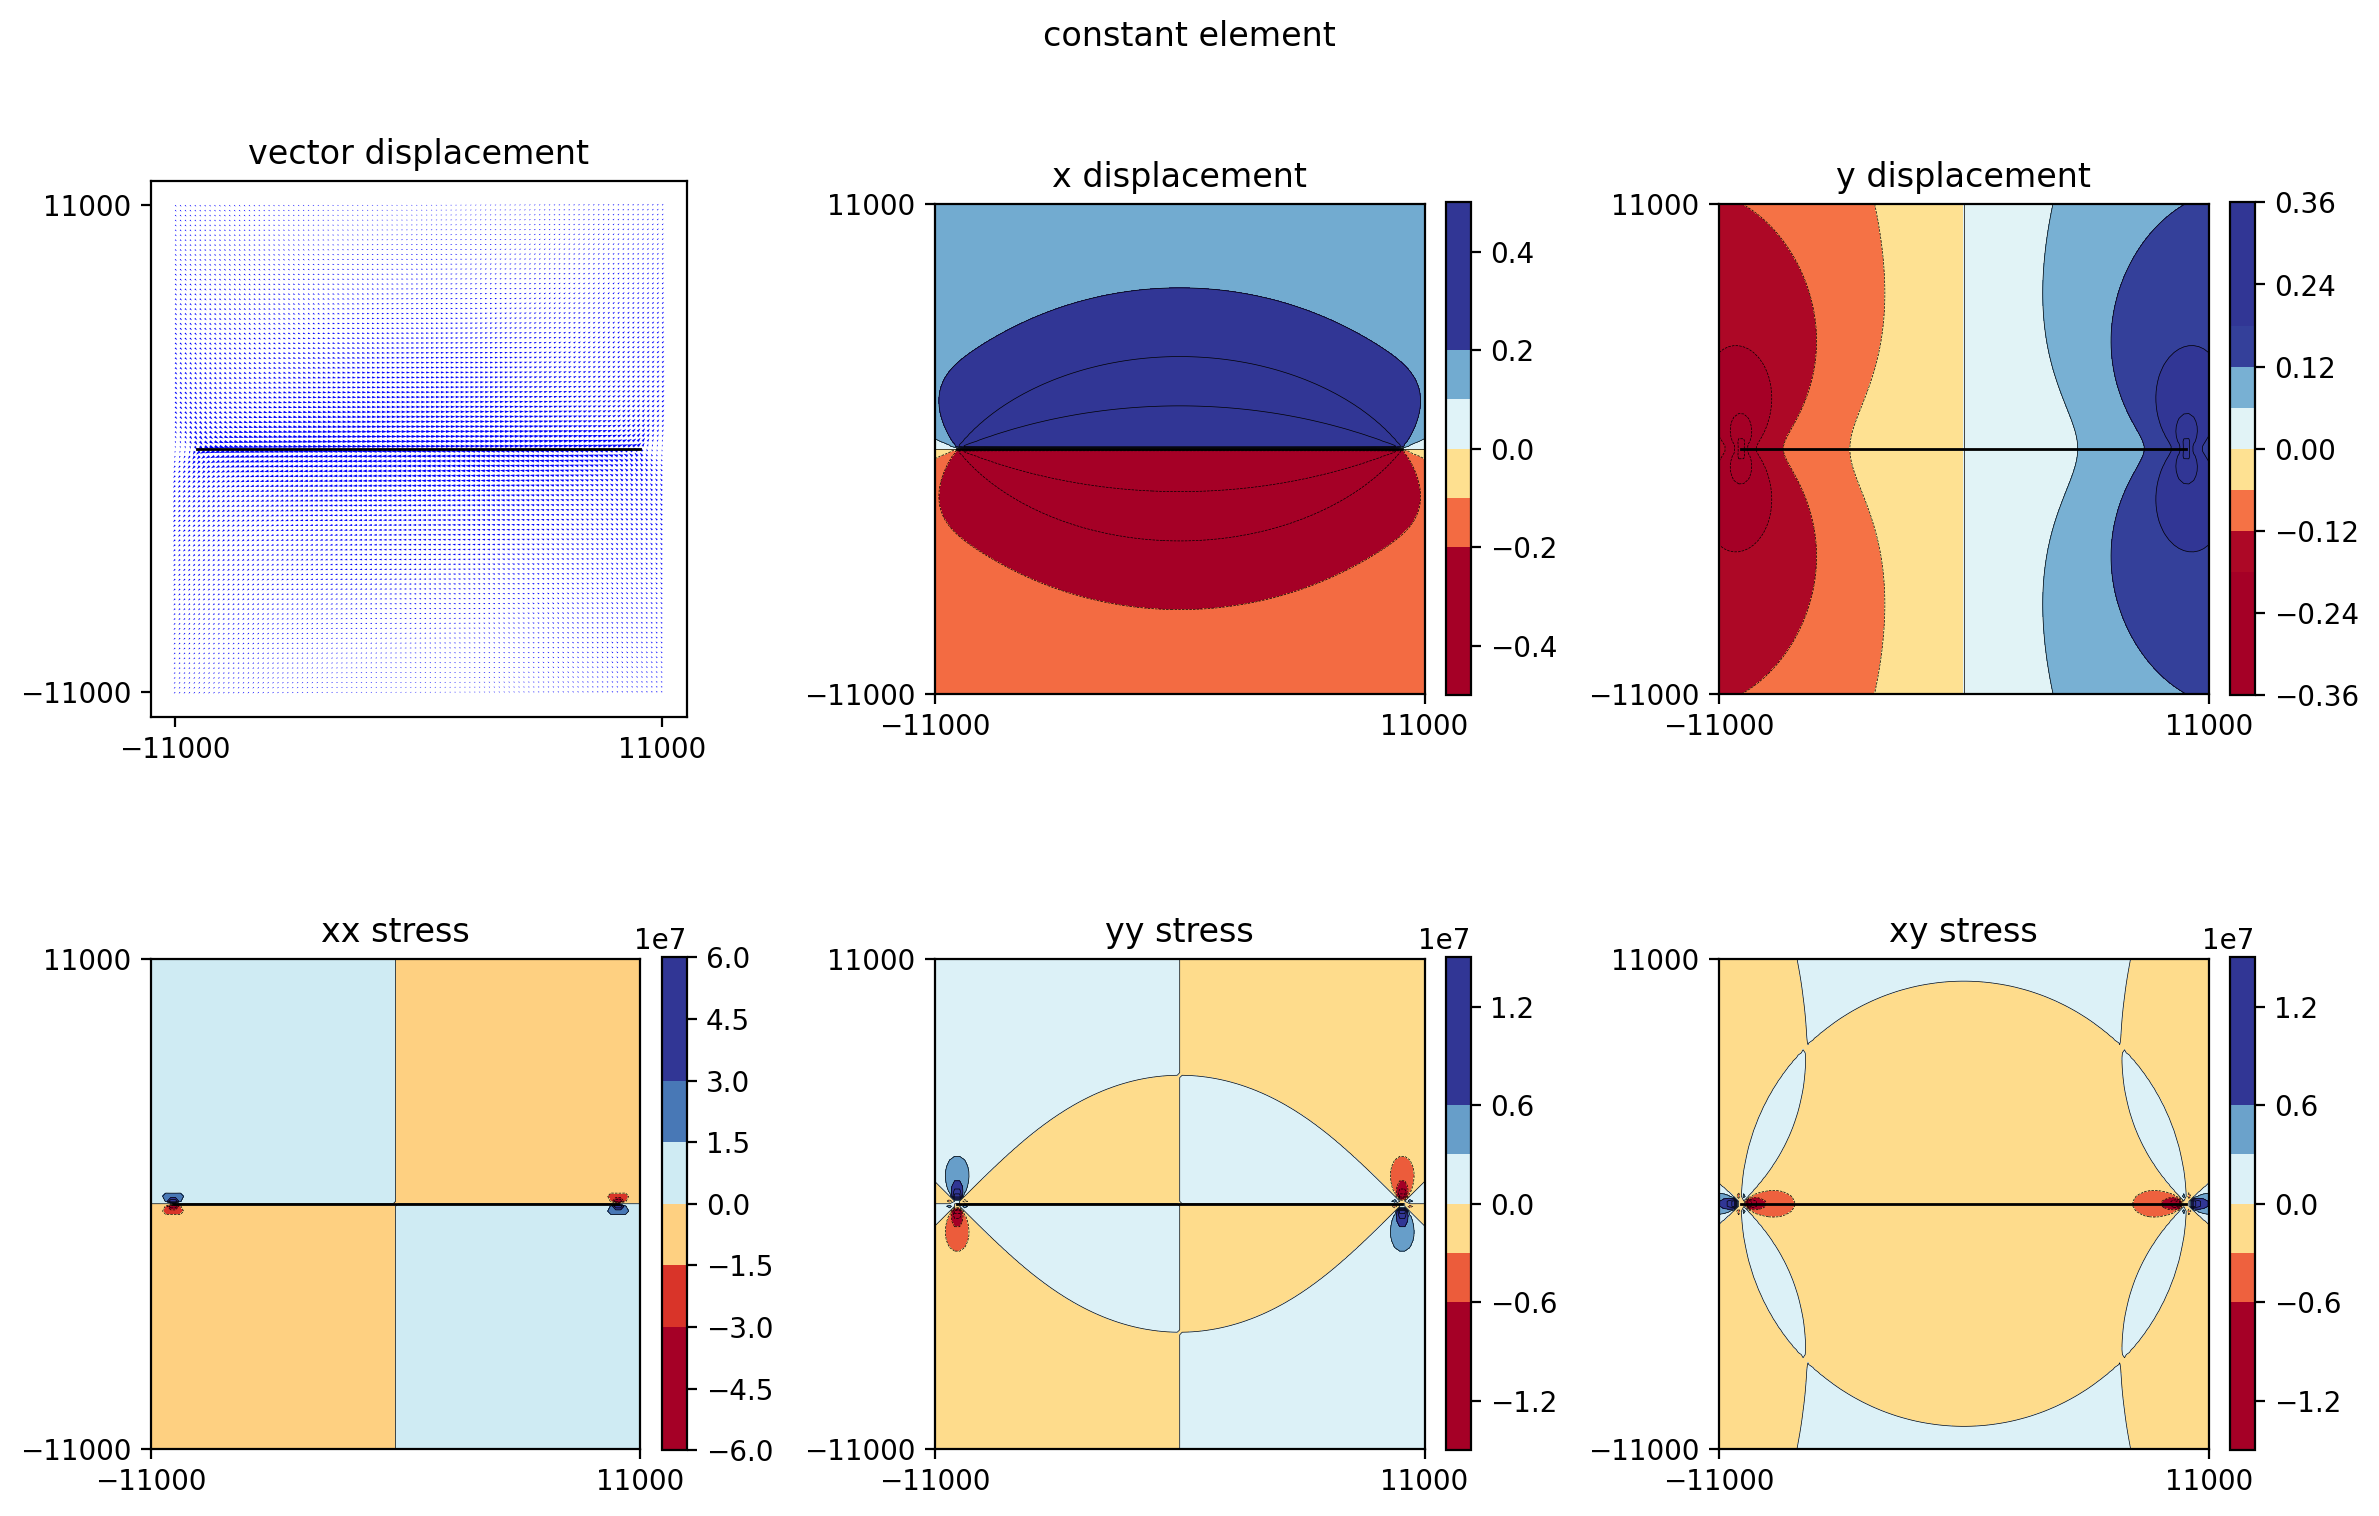

In [8]:
strike_slip_constant = 1
tensile_slip_constant = 0

displacement_constant, stress_constant = displacements_stresses_constant(
    x_obs,
    y_obs,
    elements[0]["half_length"],
    mu,
    nu,
    strike_slip_constant,
    tensile_slip_constant,
    elements[0]["x_center"],
    elements[0]["y_center"],
)

plot_fields(
    elements,
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    displacement_constant,
    stress_constant,
    "constant element",
)


# Quadratic elements
Quadratic slip elements actually have solutions composed of quadratic functions specified at three distinct locations on each element.  I'm not sure why I did this but it's pretty flexible this way.  The task is to relate the coefficients that modulate the shape of each of these three quadratic functions to create the physical slip profile that we want. Excerpting from the `Bem2d.jl` paper:

An additional and necessary step is to relate the shape function coefficients $c_i$ to the  displacement discontinuity/fault slip $\Delta u_i$ at each node. We can do this by solving for the \remove{the} coefficients $c_{i}$ that multiply each shape function $\phi_{i}$ to give the variation in slip. All we need to do is solve the linear system with slip sampled at the locations of the three element nodes, $u(x_{1}),u(x_{2}),u(x_{3})$,

$
\begin{equation}
    \begin{bmatrix}
        c_{1}\\
        c_{2}\\
        c_{3}
    \end{bmatrix}
    =
    \begin{bmatrix}
        \phi_{1}(x_{1},a) & \phi_{2}(x_{1},a) & \phi_{3}(x_{1},a)\\
        \phi_{1}(x_{2},a) & \phi_{2}(x_{2},a) & \phi_{3}(x_{2},a)\\
        \phi_{1}(x_{3},a) & \phi_{2}(x_{3},a) & \phi_{3}(x_{3},a)
    \end{bmatrix}^{-1}\begin{bmatrix}
        \Delta u(x_{1})\\
        \Delta u(x_{2})\\
        \Delta u(x_{3})
    \end{bmatrix}
\end{equation}
$

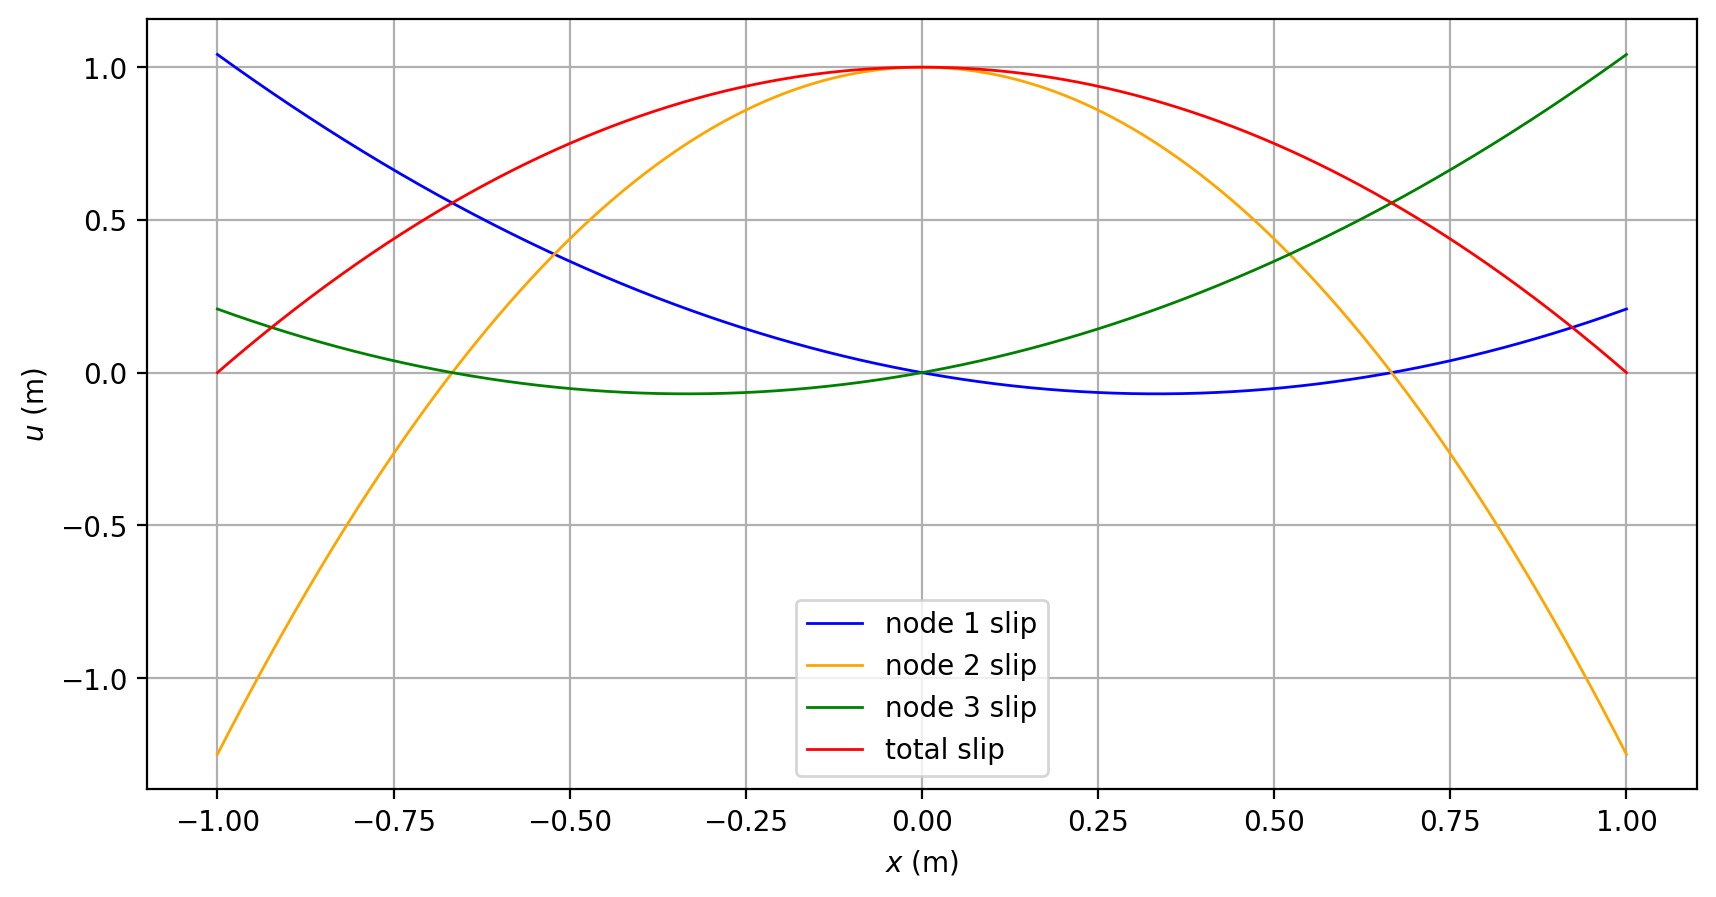

In [9]:
def phicoef(x, y, a):
    mat = np.zeros((len(x), 3))
    mat[:, 0] = (x / a) * (9 * (x / a) / 8 - 3 / 4)
    mat[:, 1] = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
    mat[:, 2] = (x / a) * (9 * (x / a) / 8 + 3 / 4)
    return np.linalg.inv(mat) @ y


def quadratic_nodes_to_slip_figure():
    linewidth = 1
    fontsize = 10
    n = 1000
    a = 1
    x = np.linspace(-a, a, n)

    # phi shape functions and coefficients
    phi1 = (x / a) * (9 * (x / a) / 8 - 3 / 4)
    phi2 = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
    phi3 = (x / a) * (9 * (x / a) / 8 + 3 / 4)
    xvals = np.array([-1.0, 0.0, 1.0])
    yvals = np.array([0.0, 1.0, 0.0]) # prescribe slip

    coef = phicoef(xvals, yvals, a)

    plt.close("all")
    plt.figure(figsize=(10, 5))
    plt.plot(
        x, coef[0] * phi1, "-", color="blue", linewidth=linewidth, label="node 1 slip"
    )
    plt.plot(
        x, coef[1] * phi2, "-", color="orange", linewidth=linewidth, label="node 2 slip"
    )
    plt.plot(
        x, coef[2] * phi3, "-", color="green", linewidth=linewidth, label="node 3 slip"
    )
    plt.plot(
        x,
        coef[0] * phi1 + coef[1] * phi2 + coef[2] * phi3,
        "-r",
        linewidth=linewidth,
        label="total slip",
    )
    plt.legend()
    plt.grid()
    plt.xlabel("$x$ (m)", fontsize=fontsize)
    plt.ylabel("$u$ (m)", fontsize=fontsize)
    plt.gca().tick_params(labelsize=fontsize)
    plt.show()


quadratic_nodes_to_slip_figure()


Text(0.5, 1.0, '$u_y$')

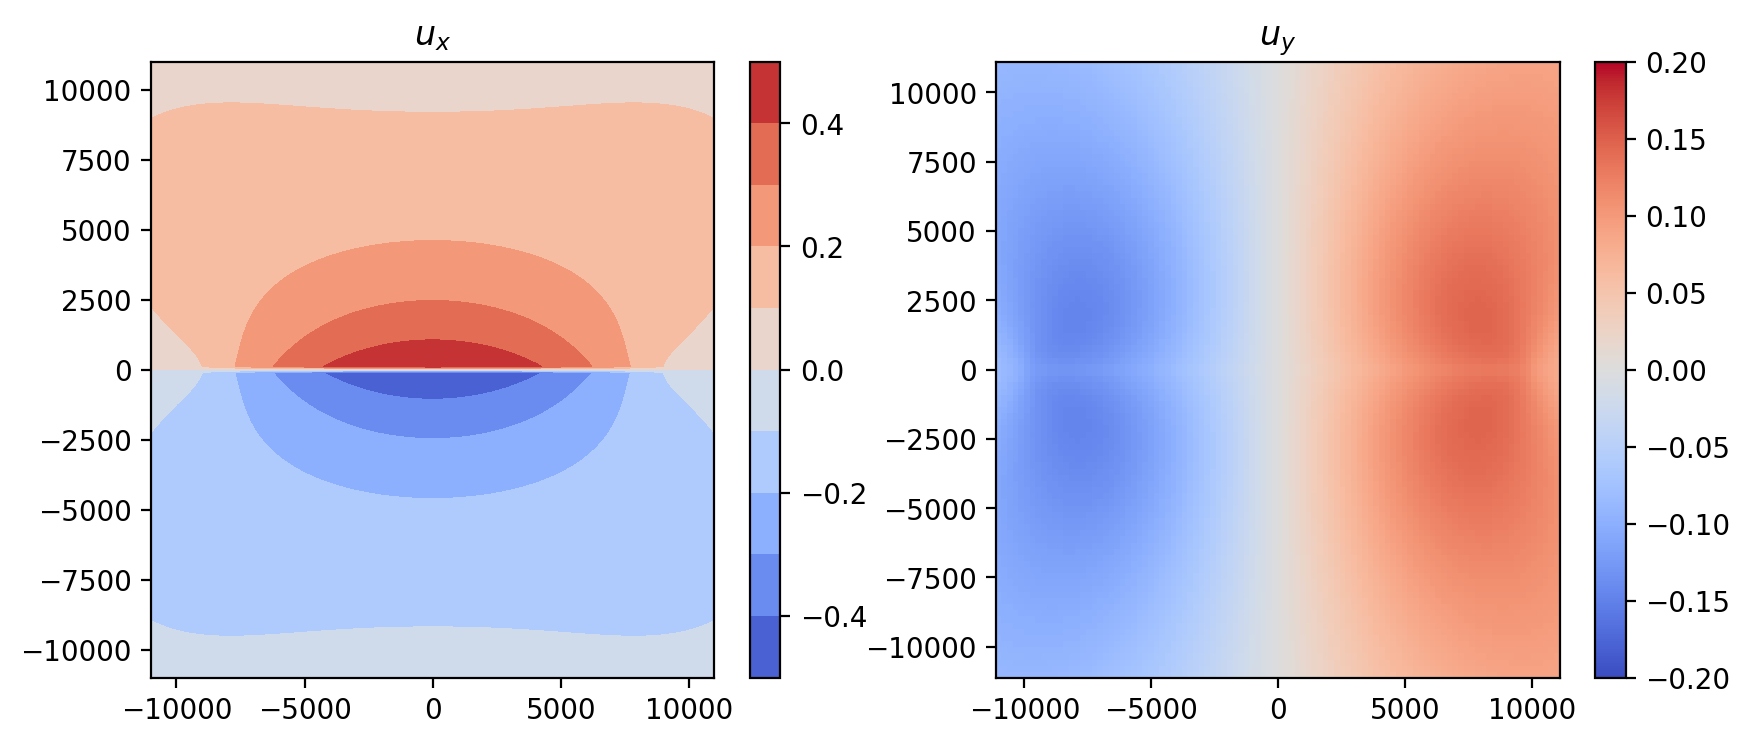

In [10]:
quadratic_coefficients = np.array([5 / 9, 1.0, 5 / 9])

strike_slip_quadratic = np.copy(quadratic_coefficients)
tensile_slip_quadratic = [0.0, 0.0, 0.0]

displacement_quadratic, stress_quadratic = displacements_stresses_quadratic(
    x_obs,
    y_obs,
    elements[0]["half_length"],
    mu,
    nu,
    strike_slip_quadratic,
    tensile_slip_quadratic,
    elements[0]["x_center"],
    elements[0]["y_center"],
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
toplot = displacement_quadratic[0,:]
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),10,cmap='coolwarm')
plt.clim(-0.5,0.5)
plt.colorbar()
plt.title("$u_x$")

plt.subplot(1, 2, 2)
toplot = displacement_quadratic[1,:]
plt.pcolor(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),cmap='coolwarm')
plt.colorbar()
plt.clim(-0.2,0.2)
plt.title("$u_y$")

# Examine at the gradients numerically

Here I think the gradient is calculated the other way round, $\frac{du_x}{dx}$ = gradient[1] not gradient[0]

As I said before in my email, I think the discontinuity in $\sigma_{xx}$ is real as is the discontinuity in $\frac{du_x}{dx}$. This really becomes clear when looking at that nice close-up plot of displacements at the bottom of this notebook.

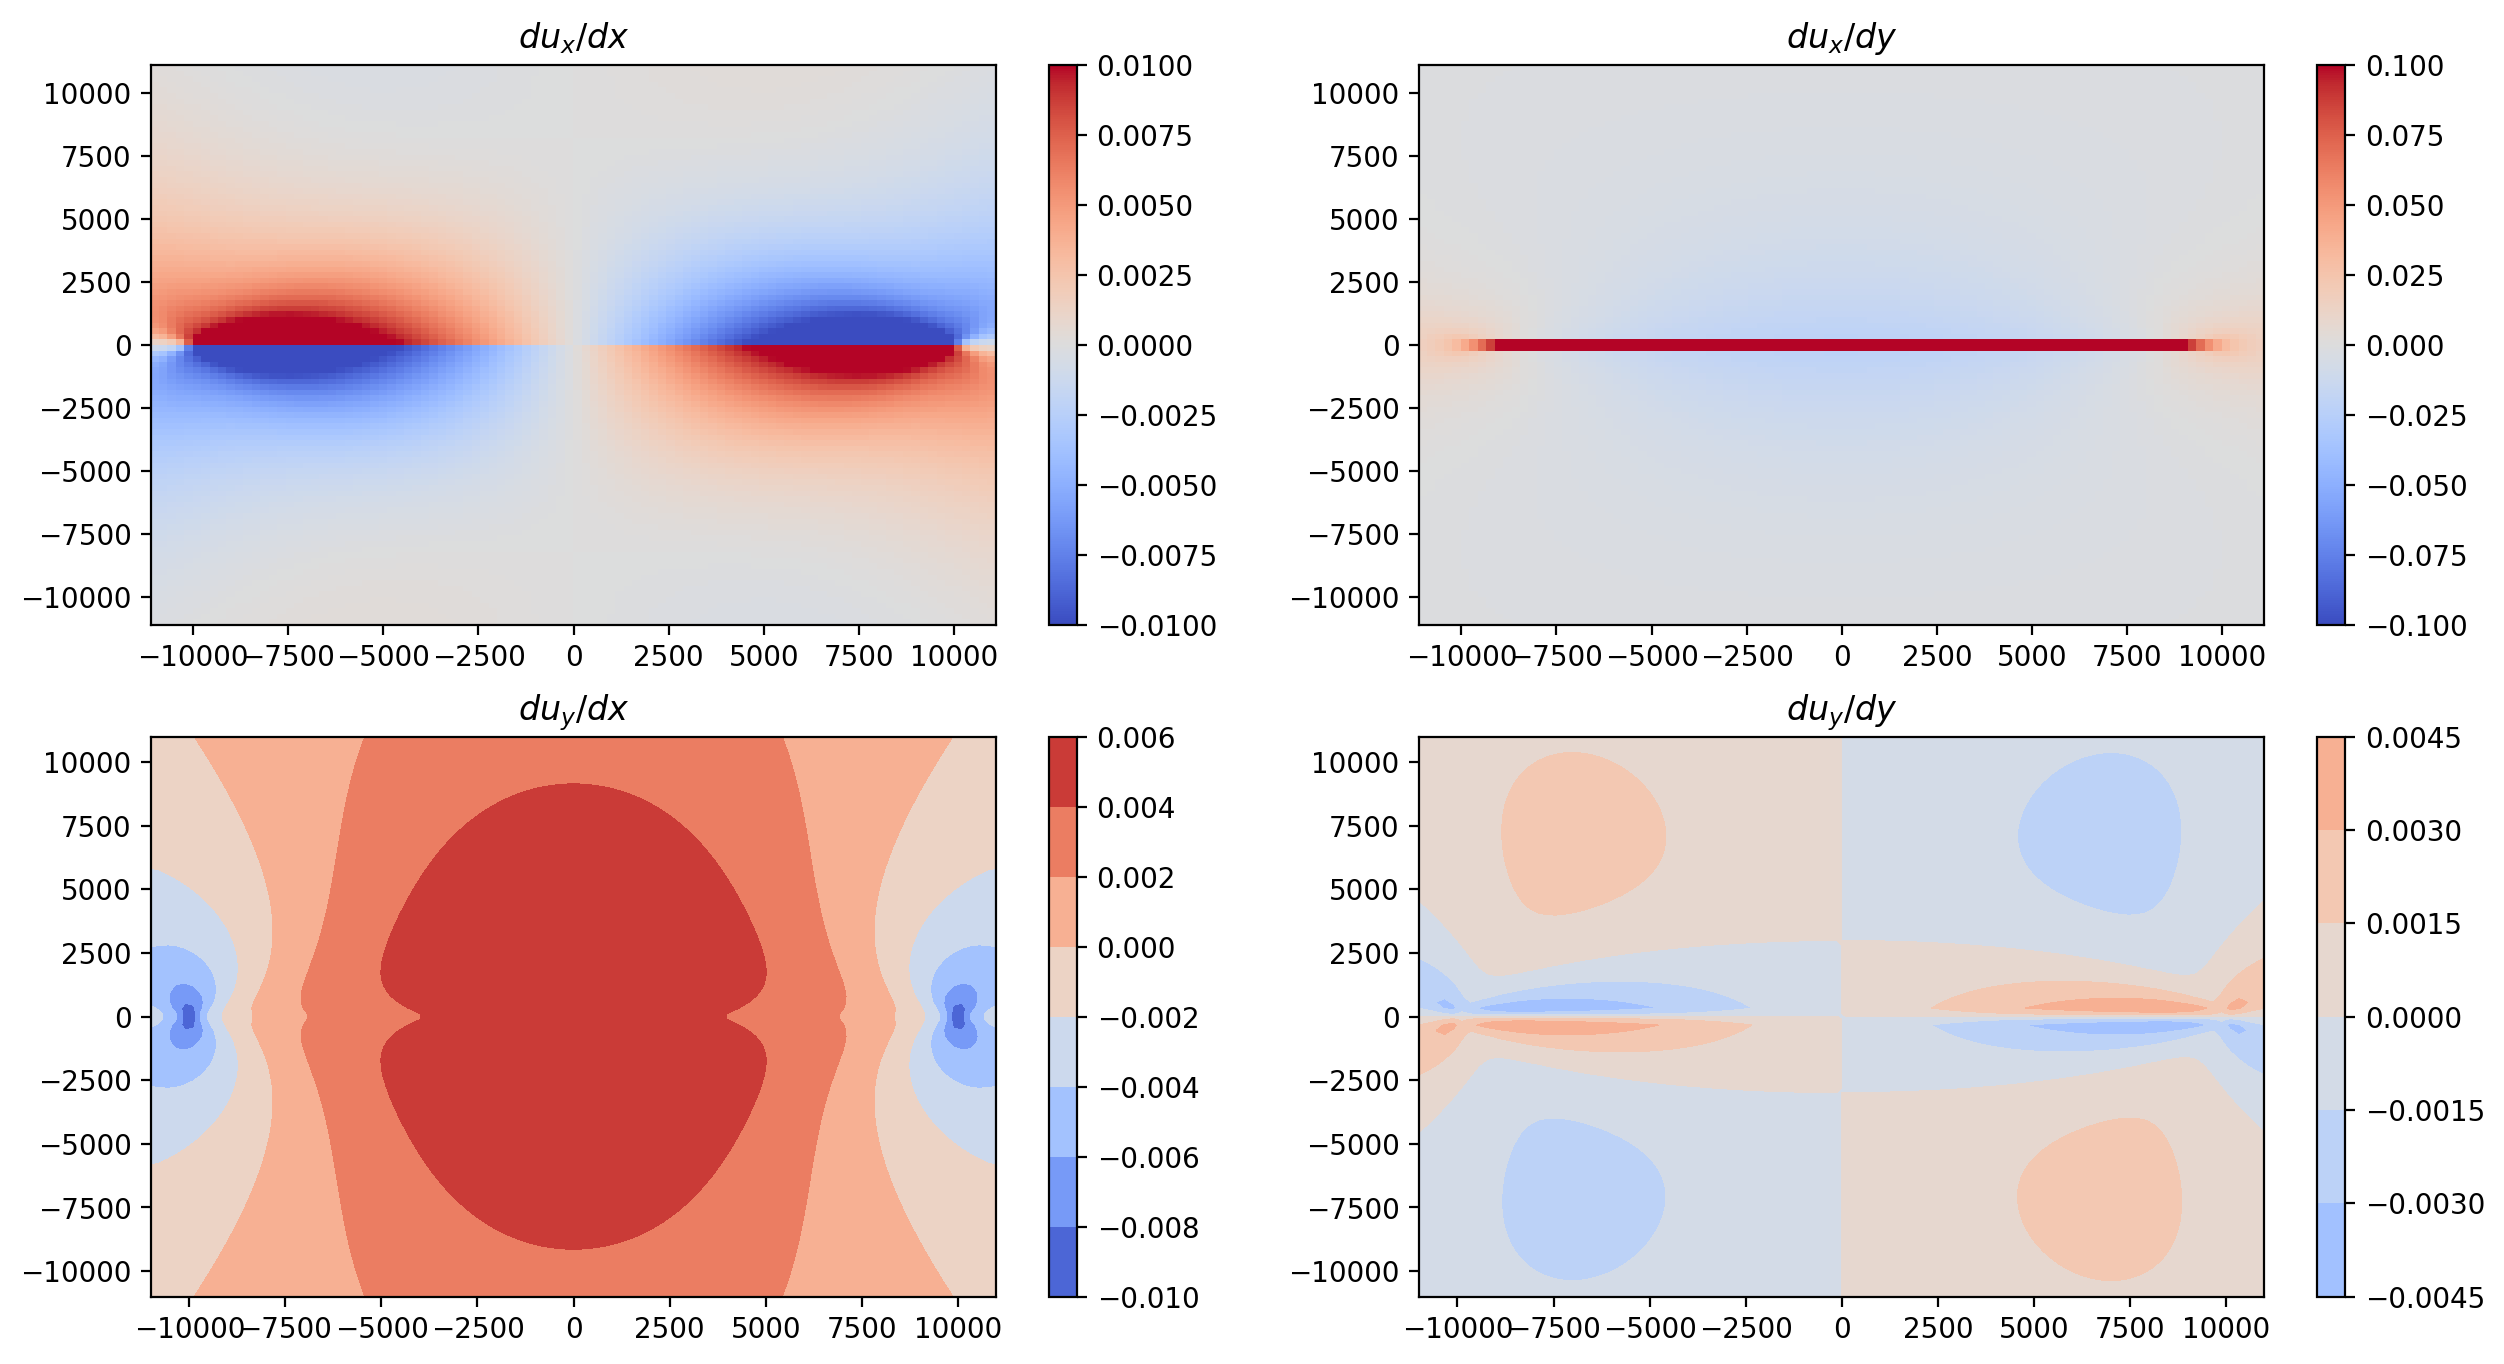

In [11]:
gradient = np.gradient(displacement_quadratic[0, :].reshape(n_pts, n_pts))
dux_dx = gradient[1]
dux_dy = gradient[0]
gradient = np.gradient(displacement_quadratic[1, :].reshape(n_pts, n_pts))
duy_dx = gradient[1]
duy_dy = gradient[0]

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.pcolor(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), dux_dx, cmap='coolwarm')
plt.clim((-0.01, 0.01))
plt.colorbar()
plt.title("$du_x/dx$")

plt.subplot(2, 2, 2)
plt.pcolor(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), dux_dy, cmap='coolwarm')
plt.colorbar()
plt.clim((-0.1, 0.1))
plt.title("$du_x/dy$")

plt.subplot(2, 2, 3)
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), duy_dx, cmap='coolwarm')
plt.colorbar()
# plt.clim((-0.1, 0.1))
plt.title("$du_y/dx$")

plt.subplot(2, 2, 4)
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), duy_dy, cmap='coolwarm')
plt.clim(-0.01, 0.01)
plt.colorbar()
plt.title("$du_y/dy$")

plt.show()


Text(0.5, 1.0, '$\\sigma_{xy}$')

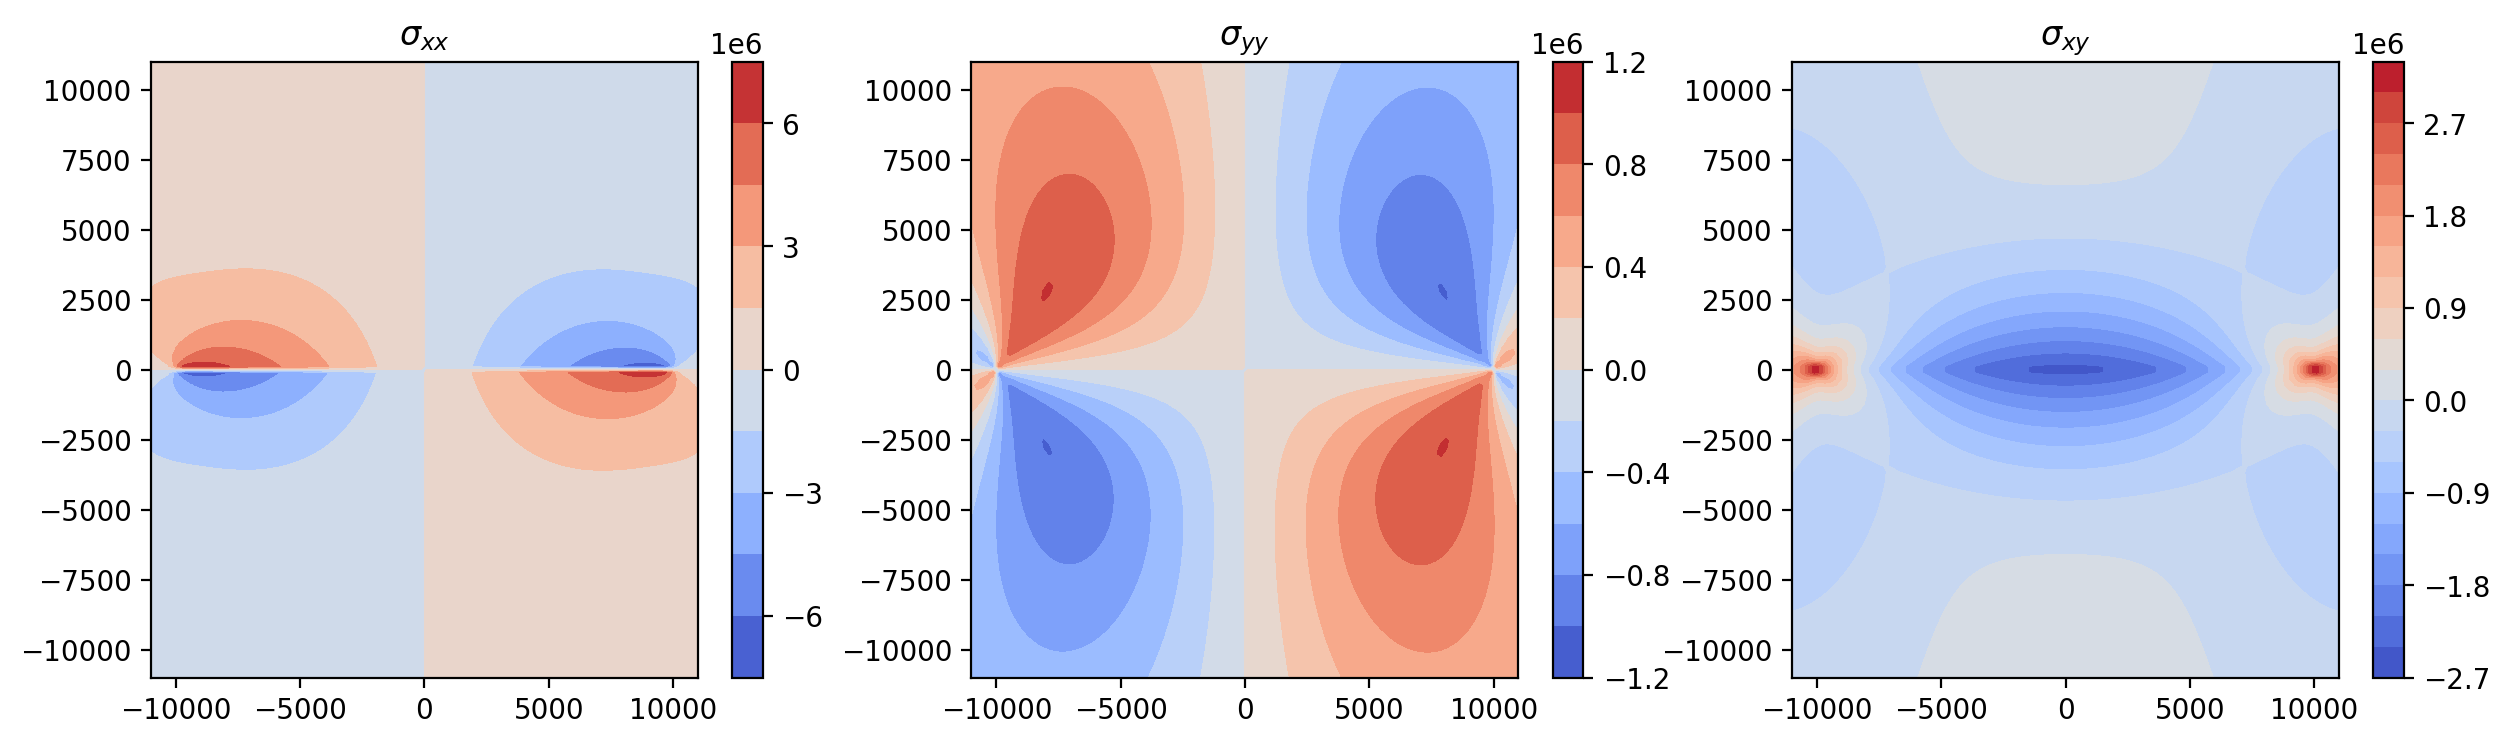

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
toplot = stress_quadratic[0,:]
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),10,cmap='coolwarm')
plt.colorbar()
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = stress_quadratic[1,:]
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),10,cmap='coolwarm')
plt.colorbar()
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = stress_quadratic[2,:]
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),20,cmap='coolwarm')
plt.colorbar()
plt.title("$\sigma_{xy}$")

# Plot a huge quiver plot

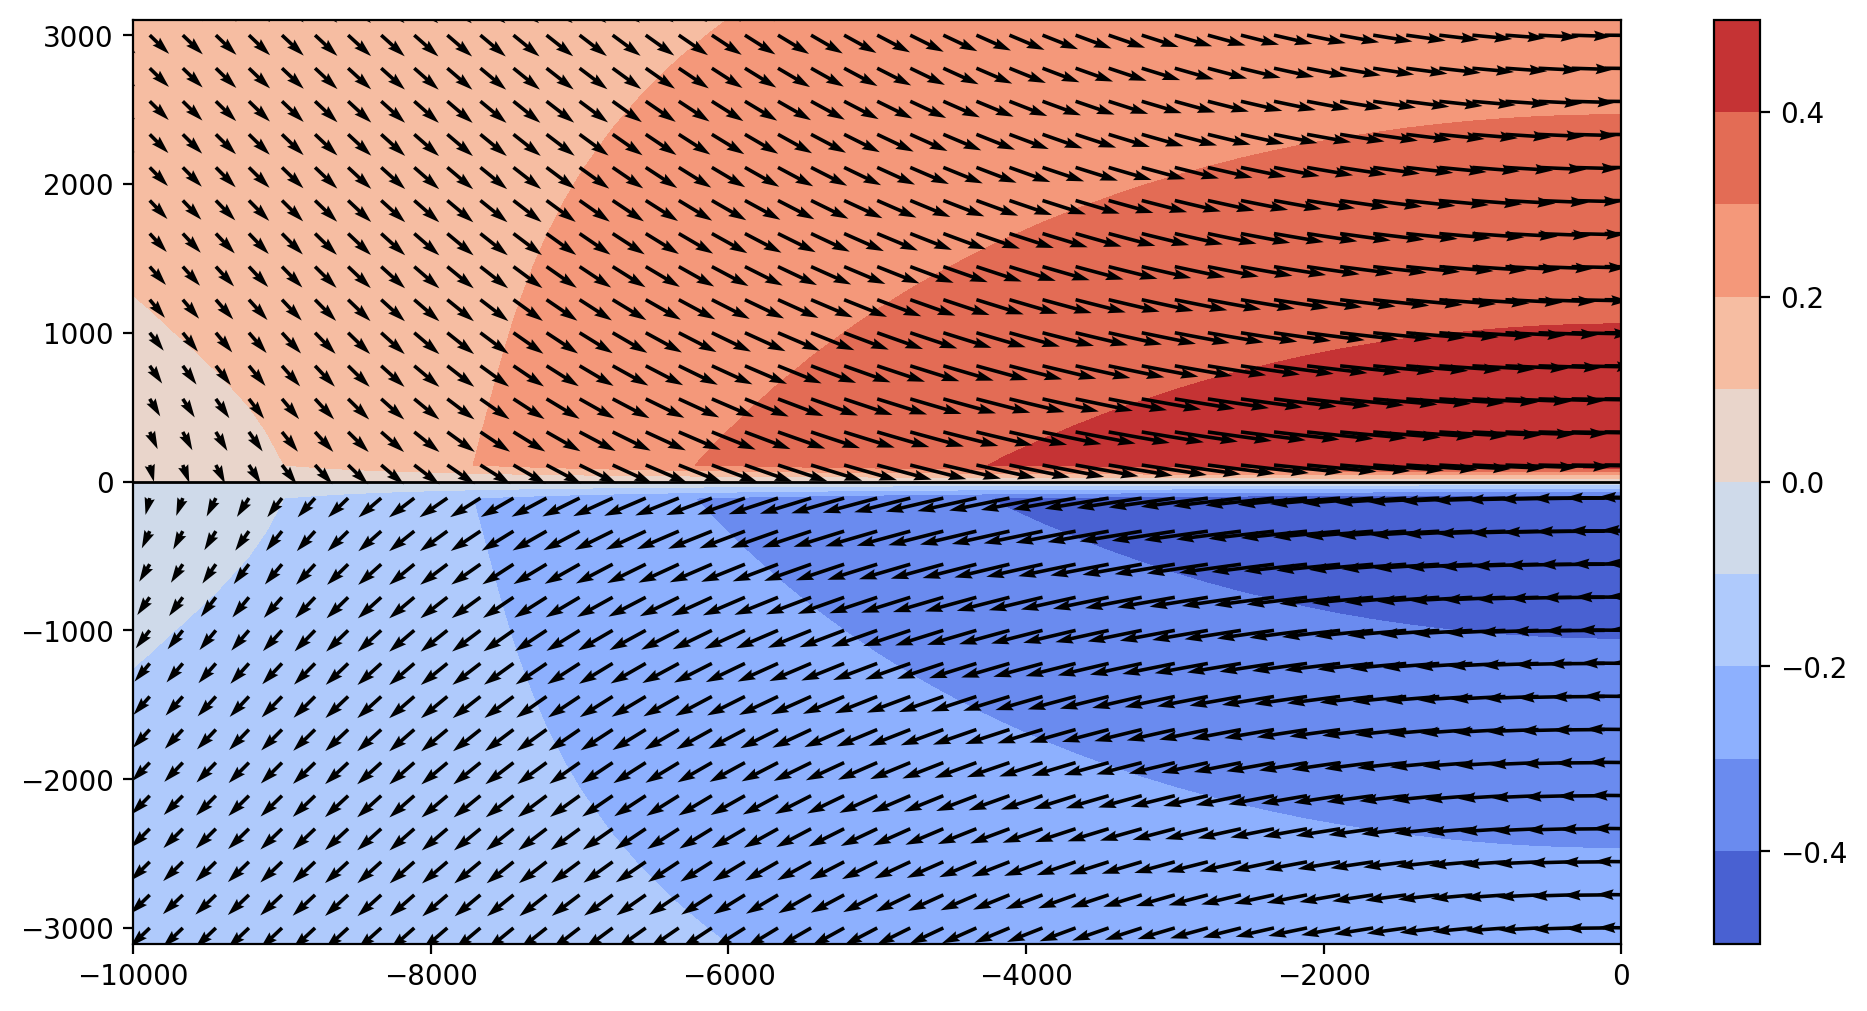

In [13]:
plt.figure(figsize=(12, 6))
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        "-k",
        linewidth=1,
    )
toplot = displacement_quadratic[0,:]
plt.contourf(x_obs.reshape(n_pts, n_pts), y_obs.reshape(n_pts, n_pts), toplot.reshape(n_pts, n_pts),10,cmap='coolwarm')
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(
    x_obs.flatten(),
    y_obs.flatten(),
    displacement_quadratic[0, :],
    displacement_quadratic[1, :],
    units="width",
    color="k",
    scale=1e1,
)
# plt.quiver(
#     x_obs.flatten(),
#     y_obs.flatten(),
#     displacement_constant[0, :],
#     displacement_constant[1, :],
#     units="width",
#     color="k",
#     scale=1e1,
# )
plt.axis("equal")
plt.xlim([-10000, 0])
plt.ylim([-2500, 2500])
plt.show()
